In [7]:
import sys
sys.path.insert(0, "/Users/aimachine/PyImage/utils")
import numpy as np
from PIL import Image
import os
from tifffile import imread
import matplotlib.pyplot as plt
from Normalize import normalizeFloat, normalizeMinMax, Path, save_tiff_imagej_compatible
from plot_utils import singleplot, plotXY, doubleplot
from GaussFit import StripFitTime, Linescan, ShiftFit,  ReadFit,FinalShiftFit
from HoughLine import show_hough_linetransform, show_ransac_points_line, show_plot, Correlation_plot,show_intensity_plot, Peak_Data
from bokeh.models import Label
from bokeh.plotting import figure, show, output_notebook
from IPython.display import clear_output
from bokeh.models import Range1d
import csv
from GaussFit import MakePath

In [8]:
targetdir = '/Users/aimachine/Documents/Oz-linescan/TestLineScan/'

Membraneimage = '/Users/aimachine/Documents/Oz-linescan/TestLineScan/Membrane.tif'

Actinimage = '/Users/aimachine/Documents/Oz-linescan/TestLineScan/Actin.tif'



#Enter time unit in seconds
Time_unit = 1
#Enter pixel to micrometer conversion
Xcalibration = 0.1032
#Enter the number of pixels to be included in the fit
Fitaround= 8


#Symmetric psf as input (micrometers)
psf = 0.17

showaftertime = 10
inisigmaguess =  psf
#Size of linescan
skip = 50
singleblock = 40 

#Number of segments
numsegments = 10
id = []
for i in range(0, numsegments):
    id.append(i)
    
MakePath(targetdir)    
save_dir = targetdir + 'ls_data_time'    
MakePath(save_dir)

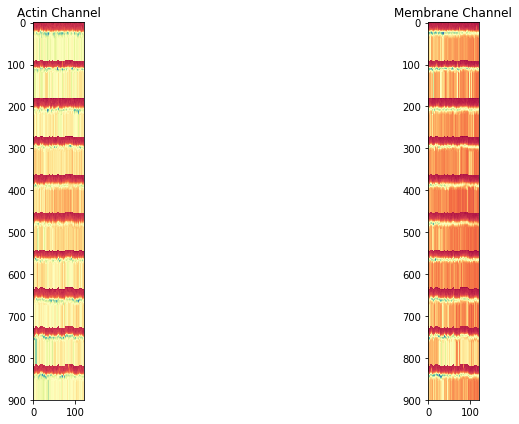

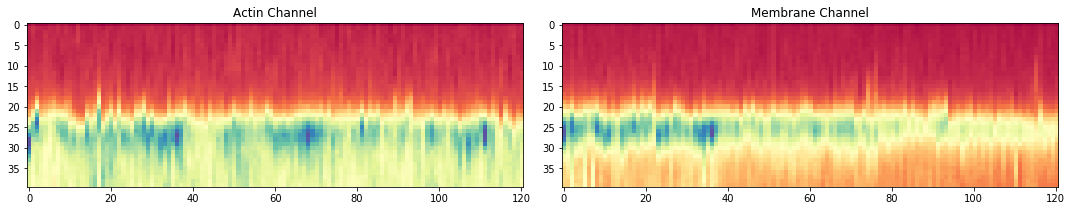

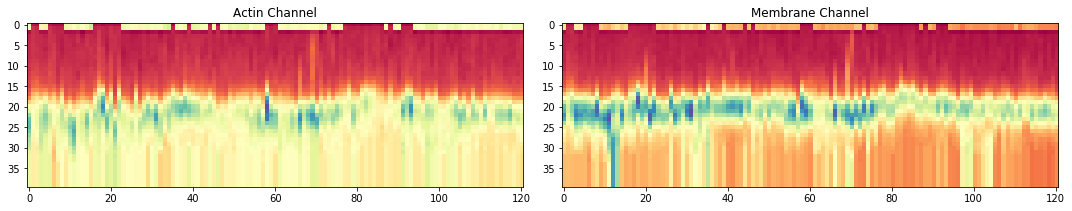

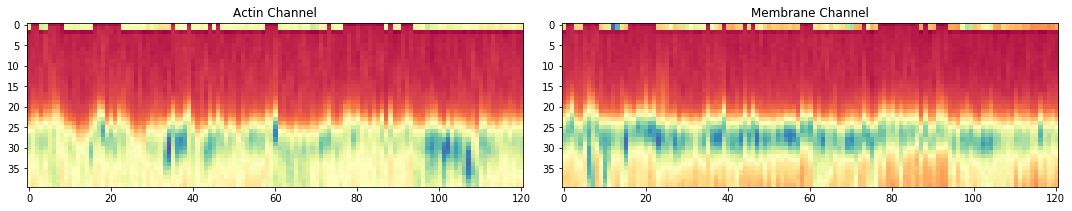

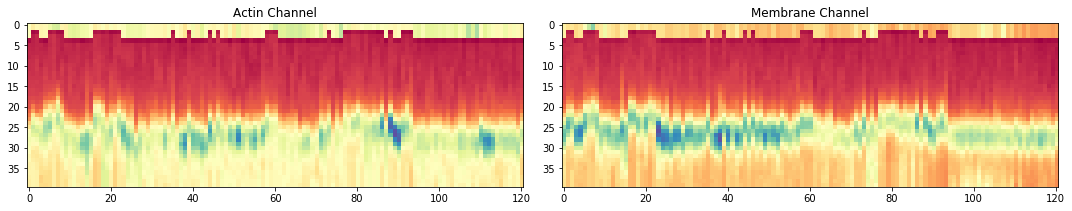

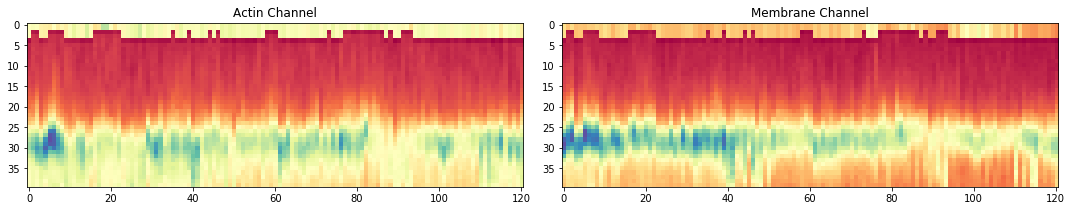

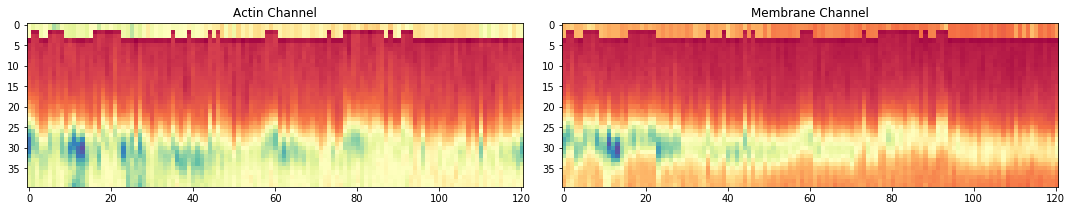

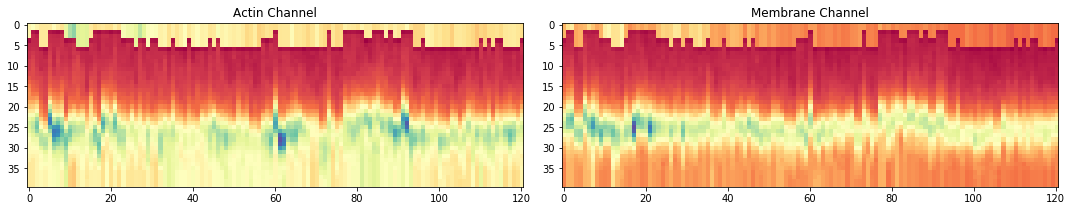

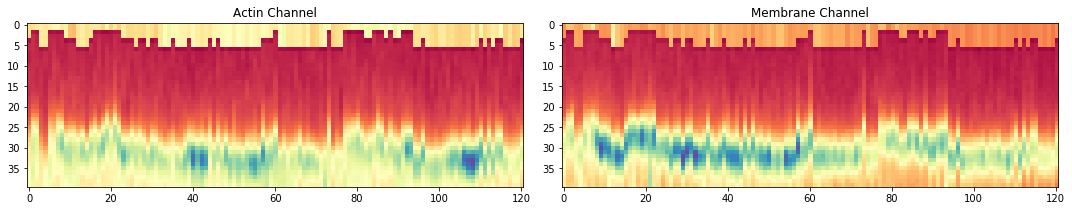

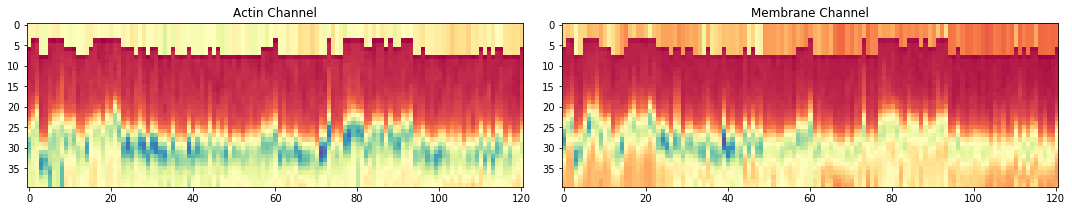

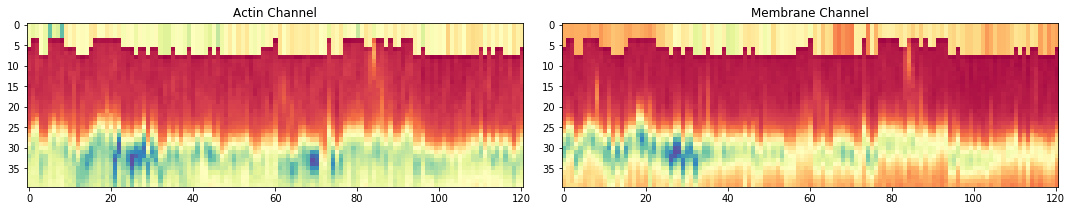

In [9]:
Actin = imread(Actinimage)
Membrane = imread(Membraneimage)
SimTime = Actin.shape[1]
doubleplot(Actin, Membrane, 'Actin Channel', 'Membrane Channel')
blockimageActin = []
blockimageMembrane = []

i = 0
while i < Actin.shape[0]:
       
   blockActin = Actin[i:i + singleblock,:]#/np.amax(Actin[i:i + singleblock,:], 0)
   blockMembrane = Membrane[i:i + singleblock,:]#/np.amax(Membrane[i:i + singleblock,:],0)
   
   blockimageActin.append(blockActin)
   blockimageMembrane.append(blockMembrane)
   doubleplot(blockActin, blockMembrane, 'Actin Channel', 'Membrane Channel')
   i = i + singleblock + skip 

halflength = int(len(blockimageActin)/2)
otherhalf = len(blockimageActin) - halflength
totallength = len(blockimageActin)

In [10]:
%%time
#Fit all blocks

Thickness = []
Intensity = []
PeakActin = []
DataActin = []
PeakMembrane = []
DataMembrane = []
Time = []
ID = []
MegaBlockActin = []
MegaBlockMembrane = []
BlockAverageActin = []
BlockAverageMembrane = []
for t in range(0, SimTime):
  BlockActin = []
  BlockMembrane = []
  for i in range(0, totallength):
    
     
    
     print('block id', i+1, 'time averaged', t) 
     currentid = i+1
     ID.append(i + 1)
     Actin = blockimageActin[i]
     Membrane = blockimageMembrane[i]
     X = []
     I = []
     membraneimageX = []
     membraneimageI = []
     strip = Actin[:Actin.shape[0],t]
     membraneimagestrip = Membrane[:Membrane.shape[0],t]
     for j in range(strip.shape[0]):
           X.append(j * Xcalibration)
           I.append(strip[j])
        
        
     X = np.asarray(X)
     I = np.asarray(I)
     for j in range(membraneimagestrip.shape[0]):    
           membraneimageX.append(j * Xcalibration)
           membraneimageI.append(membraneimagestrip[j]) 
           
     membraneimageX = np.asarray(membraneimageX)
     membraneimageI = np.asarray(membraneimageI)
     StripFitTime(X, I,membraneimageX,membraneimageI,Time_unit,Xcalibration,  Fitaround, psf, inisigmaguess, showaftertime, Thickness, Intensity, BlockActin, BlockMembrane, Time, t)
  if(len(BlockActin) > 0 and len(BlockMembrane)> 0 ):  
     ShiftFit(BlockActin, BlockMembrane,BlockAverageActin,BlockAverageMembrane, Time_unit, Xcalibration, Fitaround
             , psf, inisigmaguess, showaftertime,Thickness, Intensity,   Time, t) 
     clear_output(wait=True)
   


CPU times: user 6min 1s, sys: 30.5 s, total: 6min 31s
Wall time: 6min 6s


In [11]:
print("Thickness (min)",np.min(Thickness) *1000, "nm")
print("Thickness (median)",np.median(Thickness) *1000, "nm")
print("Thickness (max)",np.max(Thickness) *1000, "nm")
 
Thickness_intensity = np.column_stack([Thickness, Intensity]) 
Thickness_time= np.column_stack([Thickness, Time])  

Thickness (min) 4.314135707427324 nm
Thickness (median) 258.9430530206892 nm
Thickness (max) 10082.015180473618 nm


In [12]:

hist, edges = np.histogram((Thickness), density=False, bins='auto')
p = figure(title="Estimated Cortex Thickness = " + str('%.5f'%np.abs(edges[np.argmax(hist)] * 1000)) + 'nm', y_axis_label='Counts',x_axis_label='Thickness(um)')
listedges = edges.tolist()
listhist = hist.tolist()
output_notebook()
p.quad(top=hist, bottom=0, left=edges[:-1], right=edges[1:],
    fill_color="#036564", line_color="#033649")
for  i in range(0,len(listhist)):
  if listhist[i] > 0:
   mytext = Label(x=listedges[i], y=listhist[i], text=str('%.4f'%listedges[i]))
   p.add_layout(mytext)
show(p)    


Loading BokehJS ...

X: 140.0301234341086 Y:  0.2829135983058594
Standard deviation: 44.712329142714765
X: 131.90938381156832 Y:  0.4770051143651355
Standard deviation: 44.712329142714765


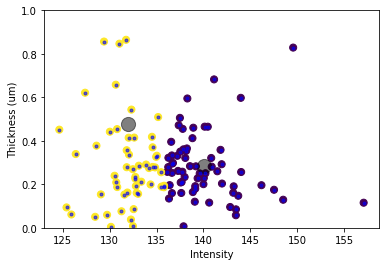

In [13]:

num_clusters = 2
show_intensity_plot(Thickness_intensity, ymin = 0, ymax = 1, num_clusters = num_clusters )
    


X: 29.275862068965562 Y:  0.3151822214868808
Standard deviation: 2119.884557070968
X: 89.53333333333336 Y:  0.42640296035088715
Standard deviation: 2119.884557070968


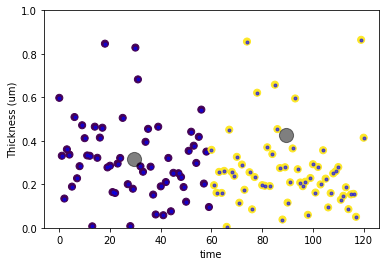

In [14]:
show_intensity_plot(Thickness_time, ymin = 0, ymax = 1, num_clusters = num_clusters, title = 'time' )


/Users/aimachine/PyImage/utils/GaussFit.py:596: RuntimeWarning: invalid value encountered in double_scalars
  m_left = (self.i[self.left_index_right] - self.i[self.left_index_left]) /  (self.x[self.left_index_right] - self.x[self.left_index_left])
/Users/aimachine/PyImage/utils/GaussFit.py:612: RuntimeWarning: invalid value encountered in double_scalars
  m_right = (self.i[self.right_index_right] - self.i[self.right_index_left]) / (self.x[self.right_index_right] - self.x[self.right_index_left])


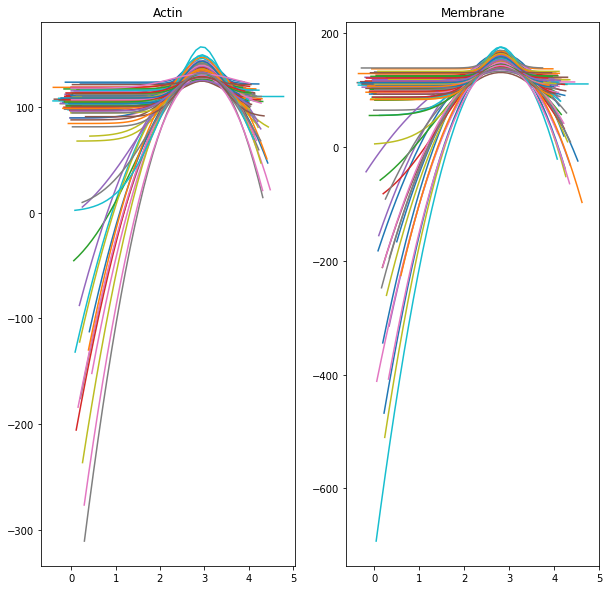

Membrane Fit: (Amp, Sigma, PeakPos, C) [ 31.7964785    0.40363924   2.82790789 117.92370167]
Actin Fit: [ 28.12268785   0.46464133   2.96933908 110.05488596]


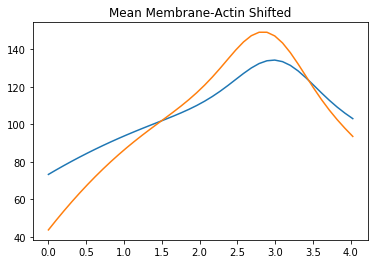

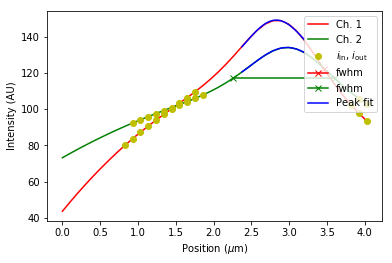

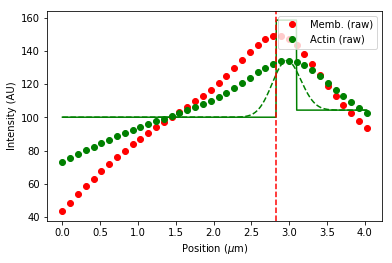

Thickness (nm), center cortex , cortical actin intensity (from fit) 266.41026837232033 2.96111302381462 158.54233951515835


In [15]:

FinalThickness = []
FinalIntensity = []
FinalTime = []
FinalShiftFit(BlockAverageActin, BlockAverageMembrane, Time_unit, Xcalibration, Fitaround
             , psf, inisigmaguess, showaftertime,FinalThickness, FinalIntensity,   FinalTime, 0)
    